In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent

('2017-08-23',)

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

last_date = dt.datetime.strptime(most_recent[0], '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
querydate = dt.date(last_date.year -1, last_date.month, last_date.day)
querydate

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()


# Perform a query to retrieve the data and precipitation scores
precipitation = pd.DataFrame(queryresult, columns=['Date','Precipitation'])
precipitation = precipitation.dropna(how='any')
precipitation = precipitation.sort_values(["Date"], ascending=True)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation = precipitation.set_index("Date")
precipitation.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


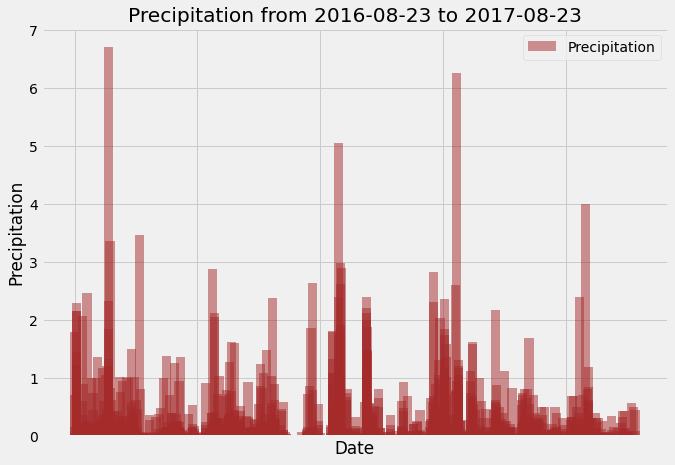

In [11]:
# Using Pandas with Matplotlib to plot the data
xx = precipitation.index.tolist()
yy = precipitation['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(xx,yy,width = 6 ,color='brown', alpha=0.5, align="center",label='Precipitation')
plt.tick_params(
    # changes apply to the x-axis   
    axis='x',
    # both major and minor ticks are affected    
    which='both', 
    # ticks along the bottom edge are off   
    bottom=False,
    # ticks along the top edge are off
    top=False, 
    # labels along the bottom edge are off
    labelbottom=False)
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {querydate} to {most_recent[0]}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
station_temps = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
station_temps

(54.0, 85.0, 71.66378066378067)

<AxesSubplot:ylabel='Frequency'>

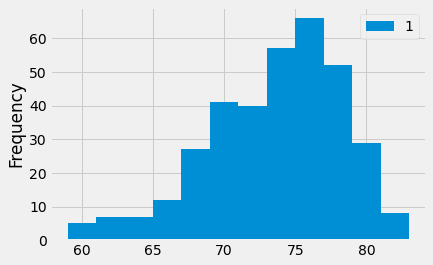

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_highest_obs = active_stations[0][0]

results = session.query(Measurement.date, Measurement.tobs).\
                        filter(Measurement.date >= "2016-08-24").\
                        filter(Measurement.date <= "2017-08-23").\
                        filter(Measurement.station == station_highest_obs).all()

# convert to dataframe
results_df = pd.DataFrame(results)

# historgram 
results_df.plot.hist(bins=12)

In [18]:
# Using calc_temps will accept start date and end date in the format '%Y-%m-%d' 
# Provides minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Using function `calc_temps` to calculate the tmin, tavg, and tmax 
# Using the previous year's data for those same dates.
startdate = '2016-02-28'
enddate = '2016-03-05'
tempresult = calc_temps(startdate,enddate)[0]
tempresult

(62.0, 69.88636363636364, 80.0)

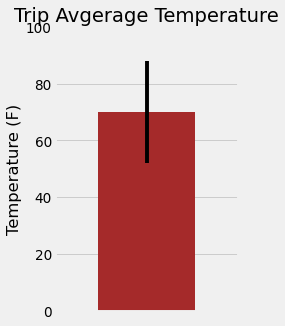

In [20]:
# Plot the results from your previous query as a bar chart. 
#"Trip Avg Temp" as your Title
# Using average temperature for the y value
# Using tmax-tmin value as the y error bar, yerr
x_pos = [0]
y_pos = [tempresult[1]]
error = [(tempresult[2] - tempresult[0])]

w = 3
h = 5
d = 70
plt.figure(figsize=(w, h), dpi=d)
plt.bar(x_pos,y_pos,color='brown', yerr=error)
plt.xlim(-0.75,0.75)
plt.title("Trip Avgerage Temperature")
plt.ylabel("Temperature (F)")
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
plt.grid(which='major', axis='y', linestyle='-')
plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sorted in descending order by precipitation amount 
#lists the station, name, latitude, longitude, and elevation

startdate = '2016-01-01'
enddate = '2016-01-07'

sel = [Measurement.station,func.sum(Measurement.prcp)]
queryresult = session.query(*sel).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).all()
#     order_by(func.sum(Measurement.prcp).desc()).all()
stations_prec = pd.DataFrame(queryresult,columns=['Station','PrcpSum'])

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stations = pd.merge(stations_desc,stations_prec, on="Station", how="left")
stations = stations.sort_values("PrcpSum",ascending=False)
stations = stations.fillna(value = {'PrcpSum':0})
stations = stations.reset_index(drop=True)
stations

,Station,Name,Latitude,Longitude,Elevation,PrcpSum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.94
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.93
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.55
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.18
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.13
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00
7,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,0.00
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9,0.00


# Close session

In [22]:
# Close Session
session.close()